In [116]:
import pandas as pd
import plotly.graph_objects as go # plot heatmap of correlation
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr



In [89]:
# Load the datasets with the correct delimiter
speech_demographic_info_path = 'W:/Fmri_Forschung/Allerlei/JuliaS/GitHub/SubliminalVideoPriming/data/speech/combined_speech_demographic_info.csv'
factor_features_path = 'W:/Fmri_Forschung/Allerlei/JuliaS/GitHub/SubliminalVideoPriming/data/speech/factor_features.csv'

speech_demographic_info_df = pd.read_csv(speech_demographic_info_path, delimiter=';')
factor_features_df = pd.read_csv(factor_features_path, delimiter=';')
speech_demographic_info_df.head()


,bids_number,participant_id,average_mfccs_1_neg,average_mfccs_2_neg,average_mfccs_3_neg,average_mfccs_4_neg,alpha_ratio_mean_neg,alpha_ratio_sd_neg,apq11_shimmer_neg,apq3_shimmer_neg,...,CERQ_Andere Beschuldigen Norm,CERQ_Selbstbeschuldigung,CERQ_Akzeptanz,CERQ_Rumination,CERQ_Positive Refokussierung,CERQ_Refokussierung auf Planung,CERQ_Positive Neubewertung,CERQ_Relativieren,CERQ_Katastrophisierung,CERQ_Andere Beschuldigen
0,Sub-058,277,82.379395,20.768499,19.860287,8.051362,7.284629,6.096077,11.421412,5.298905,...,-0.1598,18,9,10,4,7,5,4,13,5
1,Sub-035,234,91.421997,32.314178,19.888418,9.289201,10.718941,7.867776,18.531850,8.018380,...,-0.1598,12,16,17,4,8,8,12,8,5
2,Sub-034,235,70.376846,13.177592,12.432057,1.496185,7.619763,7.617054,9.548101,5.130727,...,0.3557,9,16,14,12,16,16,18,4,6
3,Sub-108,348,97.495644,11.368194,25.960098,13.172879,7.972128,7.190350,15.057472,6.300391,...,0.8711,11,11,10,7,14,10,14,5,7
4,Sub-046,260,80.037323,21.050978,8.607089,5.815983,12.940309,12.775001,10.540608,4.699568,...,5.5103,6,17,14,8,10,9,13,7,16


In [90]:
# Clean any leading/trailing spaces
factor_features_df['Speech_Feature'] = factor_features_df['Speech_Feature'].str.strip()
factor_features_df['Assigned_Factor'] = factor_features_df['Assigned_Factor'].str.strip()
factor_features_df = factor_features_df.drop('Unnamed: 0', axis=1)
factor_features_df.head()

,Speech_Feature,Assigned_Factor
0,average_mfccs_3_neg,Factor3
1,average_mfccs_4_neg,Factor3
2,alpha_ratio_mean_neg,Factor3
3,alpha_ratio_sd_neg,Factor3
4,apq11_shimmer_neg,Factor5


In [91]:
# Melt the speech_demographic_info_df to long format
melted_speech_df = speech_demographic_info_df.melt(id_vars=['bids_number', 'participant_id', 'Gender', 'Alter', 'Gender_f1_m2', 'Group_MDD1_HC2'],
                                                   var_name='Speech_Feature',
                                                   value_name='Feature_Value')

melted_speech_df['Feature_Value'] = pd.to_numeric(melted_speech_df['Feature_Value'], errors='coerce')
melted_speech_df

,bids_number,participant_id,Gender,Alter,Gender_f1_m2,Group_MDD1_HC2,Speech_Feature,Feature_Value
0,Sub-058,277,female,24,1,2,average_mfccs_1_neg,82.379395
1,Sub-035,234,female,30,1,1,average_mfccs_1_neg,91.421997
2,Sub-034,235,female,25,1,2,average_mfccs_1_neg,70.376846
3,Sub-108,348,male,26,2,1,average_mfccs_1_neg,97.495644
4,Sub-046,260,female,30,1,2,average_mfccs_1_neg,80.037323
...,...,...,...,...,...,...,...,...
28665,Sub-096,327,male,23,2,2,CERQ_Andere Beschuldigen,19.000000
28666,Sub-131,377,male,22,2,1,CERQ_Andere Beschuldigen,10.000000
28667,Sub-114,354,male,29,2,1,CERQ_Andere Beschuldigen,9.000000
28668,Sub-049,251,male,28,2,1,CERQ_Andere Beschuldigen,7.000000


In [92]:
# Merge the melted dataframe with factor_features_df
merged_df = melted_speech_df.merge(factor_features_df, on='Speech_Feature', how='left')
# Convert the Feature_Value column to numeric, forcing errors to NaN

# Filter out rows with NaN values in Assigned_Factor
filtered_df = merged_df.dropna(subset=['Assigned_Factor'])
filtered_df.head() # list with all participants and respective speech features + demographics!

,bids_number,participant_id,Gender,Alter,Gender_f1_m2,Group_MDD1_HC2,Speech_Feature,Feature_Value,Assigned_Factor
188,Sub-058,277,female,24,1,2,average_mfccs_3_neg,19.860287,Factor3
189,Sub-035,234,female,30,1,1,average_mfccs_3_neg,19.888418,Factor3
190,Sub-034,235,female,25,1,2,average_mfccs_3_neg,12.432057,Factor3
191,Sub-108,348,male,26,2,1,average_mfccs_3_neg,25.960098,Factor3
192,Sub-046,260,female,30,1,2,average_mfccs_3_neg,8.607089,Factor3


In [93]:
# Pivot the filtered dataframe to have one row per participant, summarizing feature values by factor
pivot_df = filtered_df.pivot_table(
    index=['bids_number', 'participant_id', 'Gender', 'Alter', 'Gender_f1_m2', 'Group_MDD1_HC2'],
    columns='Assigned_Factor',
    values='Feature_Value',
    aggfunc='mean'
).reset_index()
#pivot_df.columns = [col[1] if col[1] else col[0] for col in pivot_df.columns.to_flat_index()]

pivot_df.head()

Assigned_Factor,bids_number,participant_id,Gender,Alter,Gender_f1_m2,Group_MDD1_HC2,Factor1,Factor2,Factor3,Factor4,Factor5
0,Sub-030,230,male,26,2,2,101.491012,86.967492,287.729601,12.775882,0.434432
1,Sub-031,232,female,21,1,2,175.879894,96.234799,310.095702,5.736330,-3.615038
2,Sub-032,233,male,25,2,2,135.927578,91.500370,281.690092,8.865056,1.089574
3,Sub-033,231,female,33,1,2,199.284034,92.464126,306.273346,9.693466,-1.713025
4,Sub-034,235,female,25,1,2,201.350161,93.406370,312.925697,13.103844,-1.995306


In [94]:
# Merge the pivoted dataframe with the original speech_demographic_info_df to include questionnaire results
final_merged_df = speech_demographic_info_df.merge(
    pivot_df, 
    on=['bids_number', 'participant_id', 'Gender', 'Alter', 'Gender_f1_m2', 'Group_MDD1_HC2'], 
    how='left'
)
final_merged_df.head()

,bids_number,participant_id,average_mfccs_1_neg,average_mfccs_2_neg,average_mfccs_3_neg,average_mfccs_4_neg,alpha_ratio_mean_neg,alpha_ratio_sd_neg,apq11_shimmer_neg,apq3_shimmer_neg,...,CERQ_Refokussierung auf Planung,CERQ_Positive Neubewertung,CERQ_Relativieren,CERQ_Katastrophisierung,CERQ_Andere Beschuldigen,Factor1,Factor2,Factor3,Factor4,Factor5
0,Sub-058,277,82.379395,20.768499,19.860287,8.051362,7.284629,6.096077,11.421412,5.298905,...,7,5,4,13,5,211.055820,90.116983,310.066987,6.448421,-1.892025
1,Sub-035,234,91.421997,32.314178,19.888418,9.289201,10.718941,7.867776,18.531850,8.018380,...,8,8,12,8,5,144.753054,86.671935,292.716862,20.570653,-0.378461
2,Sub-034,235,70.376846,13.177592,12.432057,1.496185,7.619763,7.617054,9.548101,5.130727,...,16,16,18,4,6,201.350161,93.406370,312.925697,13.103844,-1.995306
3,Sub-108,348,97.495644,11.368194,25.960098,13.172879,7.972128,7.190350,15.057472,6.300391,...,14,10,14,5,7,100.676719,80.555431,287.221409,20.052493,0.966893
4,Sub-046,260,80.037323,21.050978,8.607089,5.815983,12.940309,12.775001,10.540608,4.699568,...,10,9,13,7,16,208.491956,93.388705,295.109334,4.499654,-3.060219


In [95]:
# Identify columns related to questionnaire results
questionnaire_cols = [col for col in final_merged_df.columns if col.startswith('CERQ_') or col in [
    'BVAQ_New', 'BDI-II Sum score', 'STAI2', 'STAI1', 'WMS Correct Norm', 'WMS Correct',
    'Error B Norm', 'TM B Norm', 'B/A Norm', 'B/A', 'TM A', 'TM Practice A', 'TM B',
    'TM Practice B', 'Error A', 'Error B', 'Hamilton Score Norm', 'Hamilton Score',
    'DigitSpan_Forwards_Span', 'DigitSpan_ForwardsTotal Score', 'DigitSpan_Backwards_Span',
    'DigitSpan_Backwards_Total Score', 'DERS_Gesamtwert', 'DERS_Gesamtwert Norm',
    'DERS_Nicht-Akzeptanz emotionalerReaktionen Norm', 'DERS_Probleme mit zielorientiertem Verhalten Norm',
    'DERS_Impulskontrollprobleme Norm', 'DERS_Mangel an emotionaler Aufmerksamkeit Norm',
    'DERS_Eingeschränkter Zugang zu Emotionsregulations-Strategien Norm', 'DERS_Mangel an emotionaler Klarheit Norm',
    'DERS_Nicht-Akzeptanz emotionalerReaktionen', 'DERS_Probleme mit zielorientiertem Verhalten',
    'DERS_Impulskontrollprobleme', 'DERS_Mangel an emotionaler Aufmerksamkeit',
    'DERS_Eingeschränkter Zugang zu Emotionsregulations-Strategien', 'DERS_Mangel an emotionaler Klarheit'
]]

# Select the factor columns and questionnaire result columns
factor_cols = ['Factor1', 'Factor2', 'Factor3', 'Factor4', 'Factor5']
selected_cols = ['Gender', 'Alter', 'Gender_f1_m2', 'Group_MDD1_HC2'] + factor_cols + questionnaire_cols


In [96]:
# Filter the dataframe to include only the selected columns
analysis_df = final_merged_df[selected_cols]
analysis_df

,Gender,Alter,Gender_f1_m2,Group_MDD1_HC2,Factor1,Factor2,Factor3,Factor4,Factor5,BVAQ_New,...,CERQ_Andere Beschuldigen Norm,CERQ_Selbstbeschuldigung,CERQ_Akzeptanz,CERQ_Rumination,CERQ_Positive Refokussierung,CERQ_Refokussierung auf Planung,CERQ_Positive Neubewertung,CERQ_Relativieren,CERQ_Katastrophisierung,CERQ_Andere Beschuldigen
0,female,24,1,2,211.055820,90.116983,310.066987,6.448421,-1.892025,41,...,-0.1598,18,9,10,4,7,5,4,13,5
1,female,30,1,1,144.753054,86.671935,292.716862,20.570653,-0.378461,49,...,-0.1598,12,16,17,4,8,8,12,8,5
2,female,25,1,2,201.350161,93.406370,312.925697,13.103844,-1.995306,35,...,0.3557,9,16,14,12,16,16,18,4,6
3,male,26,2,1,100.676719,80.555431,287.221409,20.052493,0.966893,58,...,0.8711,11,11,10,7,14,10,14,5,7
4,female,30,1,2,208.491956,93.388705,295.109334,4.499654,-3.060219,58,...,5.5103,6,17,14,8,10,9,13,7,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,male,23,2,2,62.276985,95.571912,308.845264,215.399084,0.509530,46,...,7.0567,5,15,18,12,20,13,18,8,19
90,male,22,2,1,77.538267,92.162608,342.397740,5.554744,1.418297,59,...,2.4175,17,13,8,9,12,12,15,7,10
91,male,29,2,1,81.025199,92.353163,313.132168,6.544897,1.650477,78,...,1.9021,16,16,15,10,14,6,7,9,9
92,male,28,2,1,79.032546,90.947254,291.405702,11.929162,-1.258574,58,...,0.8711,13,8,12,4,10,10,12,6,7


In [139]:
# Dictionary to map German column names to English column names
translation_dict = {
    'Gender': 'Gender',
    'Alter': 'Age',
    'Gender_f1_m2': 'Sex',
    'Group_MDD1_HC2': 'Group',
    'Factor1': 'Factor1',
    'Factor2': 'Factor2',
    'Factor3': 'Factor3',
    'Factor4': 'Factor4',
    'Factor5': 'Factor5',
    'BVAQ_New': 'BVAQ',
    'BDI-II Sum score': 'BDI-II',
    'STAI2': 'STAI2',
    'STAI1': 'STAI1',
    'WMS Correct Norm': 'WMS Correct Norm',
    'WMS Correct': 'WMS Correct',
    'Error B Norm': 'Error B Norm',
    'TM B Norm': 'TM B Norm',
    'B/A Norm': 'B/A Norm',
    'B/A': 'B/A',
    'TM A': 'TM A',
    'TM Practice A': 'TM Practice A',
    'TM B': 'TM B',
    'TM Practice B': 'TM Practice B',
    'Error A': 'Error A',
    'Error B': 'Error B',
    'Hamilton Score Norm': 'Hamilton Score Norm',
    'Hamilton Score': 'Hamilton Score',
    'DigitSpan_Forwards_Span': 'DigitSpan Forwards Span',
    'DigitSpan_ForwardsTotal Score': 'DigitSpan Forwards Total Score',
    'DigitSpan_Backwards_Span': 'DigitSpan Backwards Span',
    'DigitSpan_Backwards_Total Score': 'DigitSpan Backwards Total Score',
    'DERS_Gesamtwert': 'DERS Total Score',
    'DERS_Gesamtwert Norm': 'DERS Total Score Norm',
    'DERS_Nicht-Akzeptanz emotionalerReaktionen Norm': 'DERS Non-Acceptance of Emotional Reactions Norm',
    'DERS_Probleme mit zielorientiertem Verhalten Norm': 'DERS Problems with Goal-Oriented Behavior Norm',
    'DERS_Impulskontrollprobleme Norm': 'DERS Impulse Control Problems Norm',
    'DERS_Mangel an emotionaler Aufmerksamkeit Norm': 'DERS Lack of Emotional Awareness Norm',
    'DERS_Eingeschränkter Zugang zu Emotionsregulations-Strategien Norm': 'DERS Limited Access to Emotion Regulation Strategies Norm',
    'DERS_Mangel an emotionaler Klarheit Norm': 'DERS Lack of Emotional Clarity Norm',
    'DERS_Nicht-Akzeptanz emotionalerReaktionen': 'DERS Non-Acceptance of Emotional Reactions',
    'DERS_Probleme mit zielorientiertem Verhalten': 'DERS Problems with Goal-Oriented Behavior',
    'DERS_Impulskontrollprobleme': 'DERS Impulse Control Problems',
    'DERS_Mangel an emotionaler Aufmerksamkeit': 'DERS Lack of Emotional Awareness',
    'DERS_Eingeschränkter Zugang zu Emotionsregulations-Strategien': 'DERS Limited Access to Emotion Regulation Strategies',
    'DERS_Mangel an emotionaler Klarheit': 'DERS Lack of Emotional Clarity',
    'CERQ_Selbstbeschuldigung Norm': 'CERQ Self-Blame Norm',
    'CERQ_Akzeptanz Norm': 'CERQ Acceptance Norm',
    'CERQ_Rumination Norm': 'CERQ Rumination Norm',
    'CERQ_Positive Refokussierung Norm': 'CERQ Positive Refocusing Norm',
    'CERQ_Refokussierung auf Planung Norm': 'CERQ Refocusing on Planning Norm',
    'CERQ_Positive Neubewertung Norm': 'CERQ Positive Reappraisal Norm',
    'CERQ_Relativieren Norm': 'CERQ Putting into Perspective Norm',
    'CERQ_Katastrophisierung Norm': 'CERQ Catastrophizing Norm',
    'CERQ_Andere Beschuldigen Norm': 'CERQ Other-Blame Norm',
    'CERQ_Selbstbeschuldigung': 'CERQ Self-Blame',
    'CERQ_Akzeptanz': 'CERQ Acceptance',
    'CERQ_Rumination': 'CERQ Rumination',
    'CERQ_Positive Refokussierung': 'CERQ Positive Refocusing',
    'CERQ_Refokussierung auf Planung': 'CERQ Refocusing on Planning',
    'CERQ_Positive Neubewertung': 'CERQ Positive Reappraisal',
    'CERQ_Relativieren': 'CERQ Putting into Perspective',
    'CERQ_Katastrophisierung': 'CERQ Catastrophizing',
    'CERQ_Andere Beschuldigen': 'CERQ Other-Blame'
}

# Translate the column names
analysis_df.rename(columns=translation_dict, inplace=True)

In [140]:
analysis_df.to_csv('W:/Fmri_Forschung/Allerlei/JuliaS/GitHub/SubliminalVideoPriming/data/speech/speech_questionnaire_correlation.csv')

Exclude some factors

In [141]:
# List of columns to exclude from the correlation matrix
columns_to_exclude = ['TM Practice B', 'TM Practice A', 'Group']  # Add any other columns you want to exclude

# Drop the specified columns
analysis_df_filtered = analysis_df.drop(columns=columns_to_exclude)

In [142]:
# Compute the correlation matrix
correlation_matrix = analysis_df.corr()

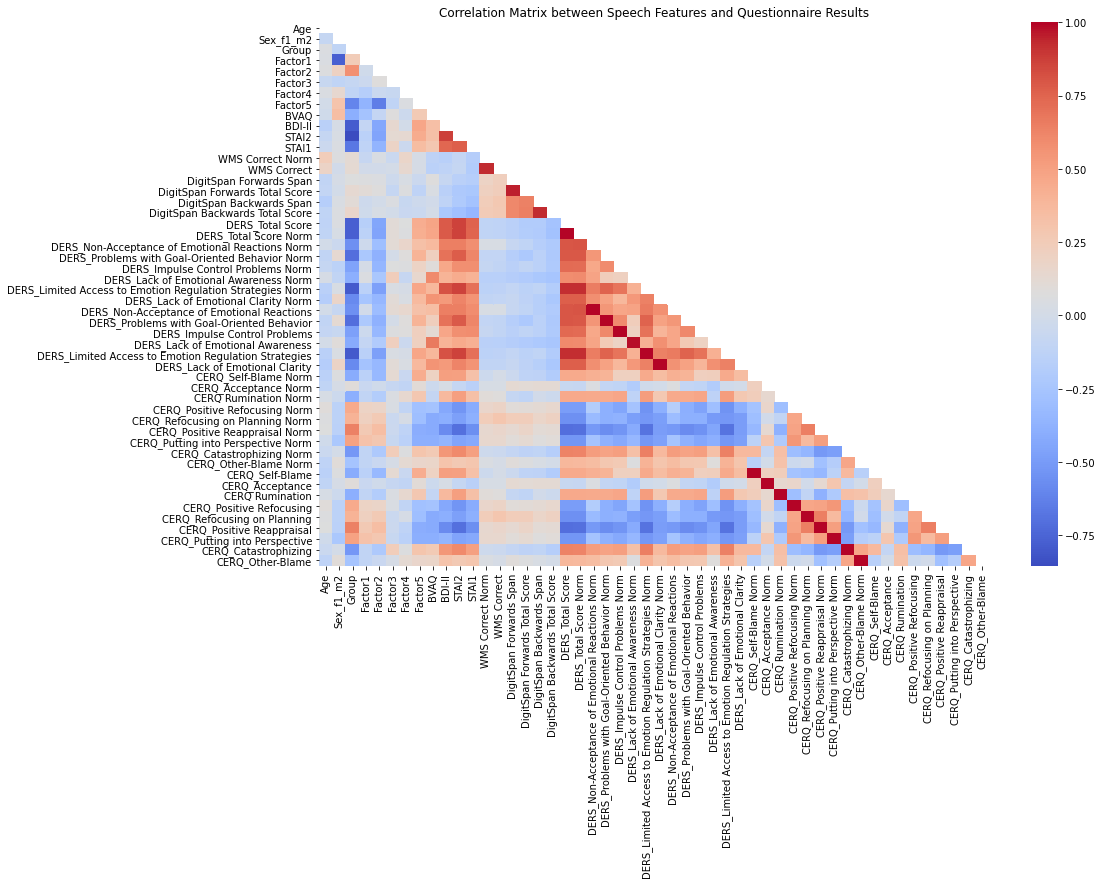

In [148]:
# Plot the correlation matrix using a heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=False, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title('Correlation Matrix between Speech Features and Questionnaire Results')
# Save the figure
plt.savefig("W:/Fmri_Forschung/Allerlei/JuliaS/GitHub/SubliminalVideoPriming/plots/speech_questinnaire_correlations_heatmap.png", bbox_inches='tight')
plt.show()

Plot interactive

In [149]:
# Assuming 'analysis_df' is already defined

# Calculate the correlation matrix
correlation_matrix = analysis_df.corr()

# Create a mask for the upper triangle (to avoid duplication in the heatmap)
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Apply the mask to the correlation matrix
correlation_matrix = correlation_matrix.mask(mask)

# Create the heatmap using plotly.graph_objects
fig = go.Figure(data=go.Heatmap(
    z=correlation_matrix.to_numpy(),
    x=correlation_matrix.columns.tolist(),
    y=correlation_matrix.index.tolist(),
    colorscale='Viridis',
    zmin=-1, zmax=1,
    showscale=True
))

# Update layout for better readability
fig.update_layout(
    title='Interactive Correlation Matrix between Speech Features and Questionnaire Results',
    xaxis=dict(tickangle=-45),
    yaxis=dict(tickangle=0),
    autosize=False,
    width=1500,
    height=1500
)

# Display the interactive heatmap
fig.show()
fig.write_html("W:/Fmri_Forschung/Allerlei/JuliaS/GitHub/SubliminalVideoPriming/plots/speech_questinnaire_correlations_interactive.html")


Apply Bonferroni correction

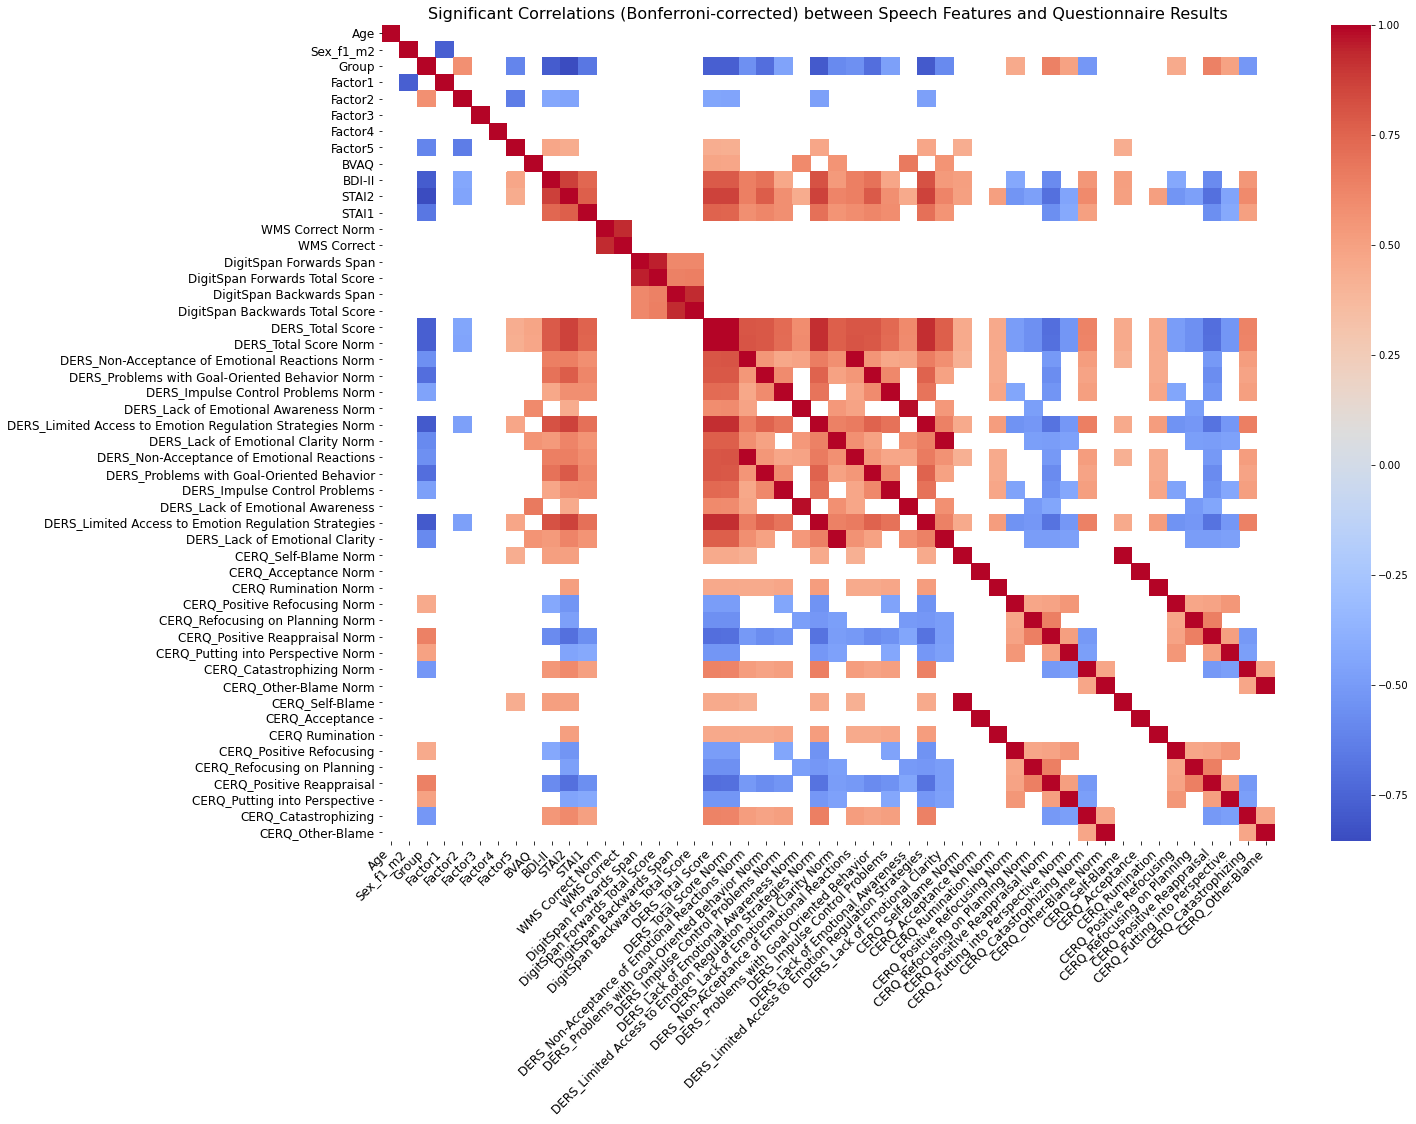

In [146]:

# Calculate the correlation matrix and the corresponding p-values matrix
def calculate_correlations(df):
    correlations = df.corr()
    p_values = df.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*correlations.shape)
    return correlations, p_values

correlation_matrix, p_values = calculate_correlations(analysis_df)

# Apply Bonferroni correction
alpha = 0.05
num_tests = p_values.size
bonferroni_threshold = alpha / num_tests

# Create a mask for significant correlations
significant_mask = (p_values < bonferroni_threshold)

# Extract all correlation values and their corresponding p-values
correlation_values = correlation_matrix.stack().reset_index()
correlation_values.columns = ['Variable1', 'Variable2', 'Correlation']

p_values_flat = p_values.stack().reset_index()
p_values_flat.columns = ['Variable1', 'Variable2', 'P-Value']

# Merge the correlation values and p-values into a single DataFrame
results_df = correlation_values.merge(p_values_flat, on=['Variable1', 'Variable2'])
results_df['Significant'] = results_df['P-Value'] < bonferroni_threshold

# Save the results to a CSV file
results_df.to_csv('W:/Fmri_Forschung/Allerlei/JuliaS/GitHub/SubliminalVideoPriming/data/speech/speech_questionnaire_correlation_results.csv', index=False)

# Mask insignificant correlations in the correlation matrix
significant_correlations = correlation_matrix.where(significant_mask)

# Plot the significant correlations using a heatmap
plt.figure(figsize=(20, 15))
sns.heatmap(significant_correlations, annot=False, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title('Significant Correlations (Bonferroni-corrected) between Speech Features and Questionnaire Results', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

# Save the figure
plt.savefig('W:/Fmri_Forschung/Allerlei/JuliaS/GitHub/SubliminalVideoPriming/plots/speech_questionnaire_correlation_significant.png', bbox_inches='tight')

# Show the plot
plt.show()


In [126]:
# Extract significant correlations
significant_pairs = []

# Loop through the correlation matrix and p-values to find significant correlations
for row in range(correlation_matrix.shape[0]):
    for col in range(row+1, correlation_matrix.shape[1]):  # only upper triangle to avoid duplicates
        if p_values.iloc[row, col] < bonferroni_threshold:
            significant_pairs.append({
                'Variable1': correlation_matrix.index[row],
                'Variable2': correlation_matrix.columns[col],
                'Correlation': correlation_matrix.iloc[row, col],
                'P-Value': p_values.iloc[row, col]
            })

# Create a DataFrame from the significant pairs
significant_pairs_df = pd.DataFrame(significant_pairs)

# Save the significant correlations to a CSV file
significant_pairs_df.to_csv('W:/Fmri_Forschung/Allerlei/JuliaS/GitHub/SubliminalVideoPriming/data/speech/significant_correlations.csv', index=False)

# Filter for correlations involving the factors
factors = ['Factor1', 'Factor2', 'Factor3', 'Factor4', 'Factor5']
significant_factors_df = significant_pairs_df[
    (significant_pairs_df['Variable1'].isin(factors)) | (significant_pairs_df['Variable2'].isin(factors))
]

# Save the factor-related significant correlations to a separate CSV file
significant_factors_df.to_csv('W:/Fmri_Forschung/Allerlei/JuliaS/GitHub/SubliminalVideoPriming/data/speech/significant_factors_correlations.csv', index=False)


(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5,
        22.5, 23.5, 24.5, 25.5, 26.5, 27.5, 28.5, 29.5, 30.5, 31.5, 32.5,
        33.5, 34.5, 35.5, 36.5, 37.5, 38.5, 39.5, 40.5, 41.5, 42.5, 43.5,
        44.5, 45.5, 46.5, 47.5, 48.5, 49.5]),
 [Text(0, 0.5, 'Age'),
  Text(0, 1.5, 'Sex_f1_m2'),
  Text(0, 2.5, 'Group_MDD1_HC2'),
  Text(0, 3.5, 'Factor1'),
  Text(0, 4.5, 'Factor2'),
  Text(0, 5.5, 'Factor3'),
  Text(0, 6.5, 'Factor4'),
  Text(0, 7.5, 'Factor5'),
  Text(0, 8.5, 'BVAQ_New'),
  Text(0, 9.5, 'BDI-II Sum score'),
  Text(0, 10.5, 'STAI2'),
  Text(0, 11.5, 'STAI1'),
  Text(0, 12.5, 'WMS Correct Norm'),
  Text(0, 13.5, 'WMS Correct'),
  Text(0, 14.5, 'DigitSpan_Forwards_Span'),
  Text(0, 15.5, 'DigitSpan_ForwardsTotal Score'),
  Text(0, 16.5, 'DigitSpan_Backwards_Span'),
  Text(0, 17.5, 'DigitSpan_Backwards_Total Score'),
  Text(0, 18.5, 'DERS_Total Score'),
  Text(0, 19.5, 'DERS_To

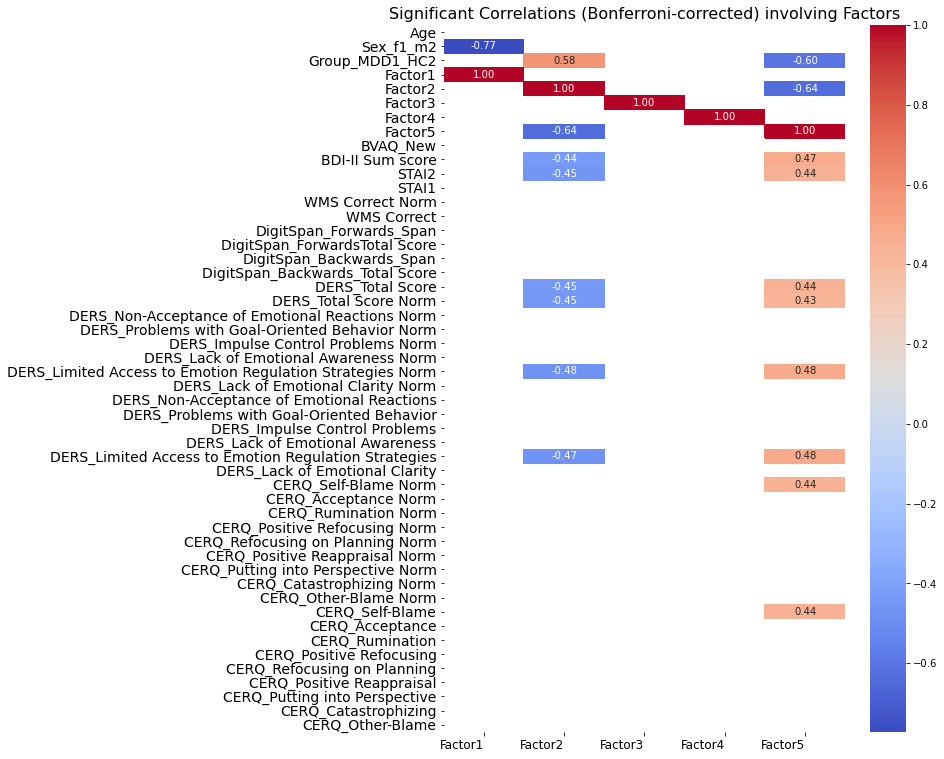

In [137]:
# Calculate the correlation matrix and the corresponding p-values matrix
def calculate_correlations(df):
    correlations = df.corr()
    p_values = df.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*correlations.shape)
    return correlations, p_values

correlation_matrix, p_values = calculate_correlations(analysis_df)

# Apply Bonferroni correction
alpha = 0.05
num_tests = p_values.size
bonferroni_threshold = alpha / num_tests

# Create a mask for significant correlations
significant_mask = (p_values < bonferroni_threshold)

# Filter for correlations involving the factors
factors = ['Factor1', 'Factor2', 'Factor3', 'Factor4', 'Factor5']
factor_correlations = correlation_matrix.loc[factors, :]
factor_p_values = p_values.loc[factors, :]

# Apply the mask for significant correlations
significant_factors_mask = factor_p_values < bonferroni_threshold
significant_factor_correlations = factor_correlations.where(significant_factors_mask)

# Transpose the DataFrame to swap x and y axes
significant_factor_correlations = significant_factor_correlations.T

# Plot the significant factor correlations using a heatmap
plt.figure(figsize=(9, 13))
sns.heatmap(significant_factor_correlations, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, annot_kws={"size": 10})
plt.title('Significant Correlations (Bonferroni-corrected) involving Factors', fontsize=16)
plt.xticks( ha='right', fontsize=12)
plt.yticks(fontsize=14)